In [1]:
import torch as t
import torchvision.transforms as transforms
import torch.nn as nn
from os.path import exists
from tqdm.notebook import tqdm
from torch.optim import Adam
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

In [2]:
device = t.device('cuda')

In [3]:
# Weight Initialization according to paper
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [4]:
# Generator Class
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d( 100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d( 256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, input):
        return self.main(input)

In [5]:
# Declaring Generator and initializing weights
netG = Generator().to(device)
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [6]:
# Discriminator Class
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [7]:
# Declaring Discriminator and initializing weights
netD = Discriminator().to(device)
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [8]:
criterion = nn.BCELoss()

real_label = 1.
fake_label = 0.

# Adam optimizers for both G and D
optimizerD = Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [9]:
# CelebA DataSet
dataset = datasets.ImageFolder(root='img_align_celeba/',
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [10]:
# DataLoader
dataloader = t.utils.data.DataLoader(dataset, batch_size=128,
                                         shuffle=True, num_workers=8)

In [11]:
# real_cpu : converted data of dataloader to working device
# b_size : batch size of each batch of dataloader(len(dataset)%batchsize!=0)
# label : label for real input/generated input
# D_x : average output of discriminator for real data sample
# noise : noise vector sampled from normal distribution
# errD_real : discriminator loss for each sample of batch
# errD_fake : discriminator loss for fake samples
# errD : errD_real + errD_fake
# D_G_z1 : average output of discriminator for generated sample
# fake : Output of Generator where input is random noise vector
# errG : discriminator loss for each sample of batch
# D_G_z2 : average output of discriminator for generated sample(after updating D)

In [12]:
if exists("generator.pt"):
    netG.load_state_dict(t.load("generator.pt"))
else :
    num_epochs=10

    print("Starting Training Loop...")

    for epoch in tqdm(range(num_epochs)):

        for i, data in enumerate(dataloader, 0):

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################

            ## Train with real inputs
            netD.zero_grad()
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = t.full((b_size,), real_label, dtype=t.float, device=device)

            output = netD(real_cpu).view(-1)
            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            noise = t.randn(b_size, 100, 1, 1, device=device)
            fake = netG(noise)
            label.fill_(fake_label)
            output = netD(fake.detach()).view(-1)
            errD_fake = criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()

            errD = errD_real + errD_fake

            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  
            output = netD(fake).view(-1)
            errG = criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()

            optimizerG.step()

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(dataloader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    netG = netG.to(t.device('cpu'))
    t.save(netG.state_dict(), "generator.pt")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


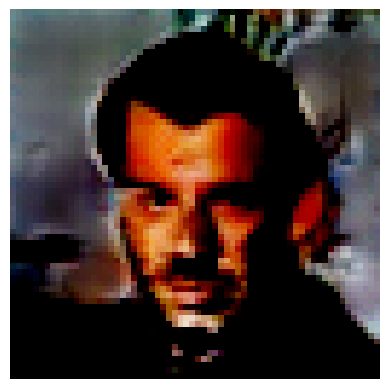

In [15]:
plt.axis('off')
img = netG(t.randn(1,100,1,1).to(device))
plt.imshow(img.detach().cpu().squeeze().transpose(2,0).transpose(0,1).numpy())